In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
TRAIN_DATASET_ROOT = '../train_mini'
TEST_DATASET_ROOT = '../test_mini'

In [3]:
print(len(os.listdir(TRAIN_DATASET_ROOT)), len(os.listdir(TEST_DATASET_ROOT)))

13 5


In [4]:
import os
import time
import torch
import pickle
import argparse
import logging
import gc
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt
from torchvision import transforms
from tensorboardX import SummaryWriter
from torch import nn
import torchvision.utils as vutils
from PIL import Image
import json
import matplotlib.pyplot as plt
%matplotlib inline


from models import Generator, Discriminator
from losses import SSIM, L1_L2_Loss
from utils import init_log, add_file_handler, print_speed, Config, AverageMeter

In [5]:
class MovingObjectsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Get the list of folder names in the root directory
        self.folder_names = [i for i in os.listdir(self.root_dir) if not i.endswith('.DS_Store')]
        
    def __len__(self):
        # Return the number of folders in the root directory
        return len(self.folder_names)
    
    def __getitem__(self, index):
        # Get the folder name corresponding to the given index
        folder_name = self.folder_names[index]
        
        # Get the list of image filenames in the folder
        image_filenames = [i for i in os.listdir(os.path.join(self.root_dir, folder_name)) 
                           if i.endswith('.png')]
        image_filenames.sort(key= lambda i: int(i.lstrip('image_').rstrip('.png')))
        
        # Load the input images and target images into separate tensors
        input_images = []
        target_images = []
        for i, image_filename in enumerate(image_filenames):
            image_path = os.path.join(self.root_dir, folder_name, f"image_{i}.png")
            image = Image.open(image_path).convert('RGB')
            if self.transform is not None:
                image = self.transform(image)
            if i < 11:
                # print(f"{image_filename} going in input")
                input_images.append(image)
            else:
                # print(f"{image_filename} going in target")
                target_images.append(image)
        
        # Convert the input and target image lists to tensors
        input_tensor = torch.stack(input_images)
        target_tensor = torch.stack(target_images)
        
        return input_tensor, target_tensor

In [6]:
def create_config_json(cfg, output_file):
    with open(output_file, "w") as outfile:
        json.dump(cfg, outfile)

cfg = {
    'meta':
    {
        'board_path': 'board',
        'board_path_epoch': 'board_epoch'
    },
    'train':
    {
        'epochs': 2,
        'batch_size': 2,
        'lr': 0.001,
        'print_frequency': 1
    },
    'model':
    {
        'input_size': [40, 60],
        'input_dim': 3,
        'hidden_dim': 64,
        'kernel_size': [3, 3],
        'future_frames': 11
    }
}
create_config_json(cfg=cfg, output_file='config_1.json')

In [7]:
main_worker = True

cfg = Config('config_1.json')
lr = cfg.train["lr"]
epochs = cfg.train["epochs"]
board_path = cfg.meta["board_path"]
board_path_epoch = cfg.meta["board_path_epoch"]
batch_size = cfg.train["batch_size"]
num_future_frame = cfg.model["future_frames"]
print_freq = cfg.train["print_frequency"]
img_size = cfg.model["input_size"]

file_identifier = f'{batch_size}_{epochs}_{img_size[0]}{img_size[1]}'


cfg.log_dict()
avg = AverageMeter()

device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Create dataloaders for train and test dataset
train_dataset = MovingObjectsDataset(
    root_dir=f'{TRAIN_DATASET_ROOT}',
    transform=transforms.Compose(
            [
                transforms.Resize((img_size[0], img_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )
    )

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False)


test_dataset = MovingObjectsDataset(
    root_dir=f'{TEST_DATASET_ROOT}',
    transform=transforms.Compose(
            [
                transforms.Resize((img_size[0], img_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )
    )


test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False)


test_iter = iter(test_loader)

In [9]:
## Check train dataset
batch_images, batch_targets = next(iter(train_loader))
print(batch_images.shape, batch_targets.shape)

torch.Size([2, 11, 3, 40, 60]) torch.Size([2, 11, 3, 40, 60])


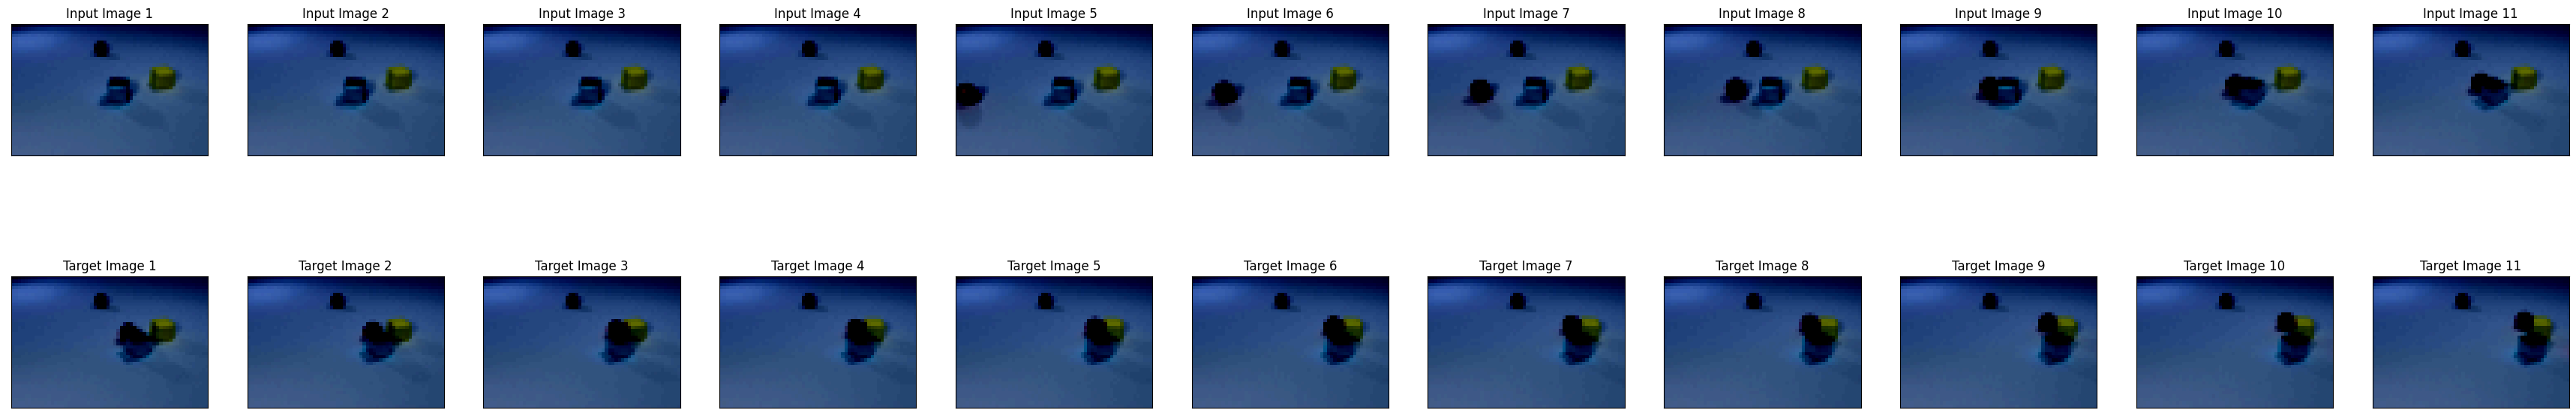

In [10]:
# Create a figure with 22 subplots
fig, axs = plt.subplots(nrows=2, ncols=11, figsize=(44, 8))

# Loop over the subplots and plot the images
for i in range(11):
    # Plot the first vector
    axs[0, i].imshow(np.clip(np.array(np.transpose(batch_images[0][i], (1, 2, 0))), 0, 1))
    axs[0, i].set_title('Input Image ' + str(i+1))
    
    # Plot the second vector
    axs[1, i].imshow(np.clip(np.array(np.transpose(batch_targets[0][i], (1, 2, 0))), 0, 1))
    axs[1, i].set_title('Target Image ' + str(i+1))
    
    # Remove the x and y ticks
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

# Show the plot
plt.show()

## Training

In [11]:
# if main_worker:
os.makedirs(os.path.join(os.getcwd(), f"logs/{file_identifier}"), exist_ok=True)
global_logger = init_log("global", level=logging.INFO)
add_file_handler("global", os.path.join(os.getcwd(), f"logs/{file_identifier}", "train.log"), level=logging.DEBUG)

global_logger.debug("==>>> Total training batches: {}".format(len(train_loader)))
global_logger.debug("==>>> Total testing batches: {}".format(len(test_loader)))

writer = SummaryWriter(os.path.join(".", board_path))
writer_epoch = SummaryWriter(os.path.join(".", board_path_epoch))

In [12]:
# Create Generator and Discriminator models
generator = Generator(cfg=cfg.model, device=device)
generator.to(device)

discriminator = Discriminator(cfg=cfg.model)
discriminator.to(device)

# Define optimizers and LR Schedulers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

generator_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=generator_optimizer, milestones=[10, 20, 30, 40], gamma=0.5
)
discriminator_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=discriminator_optimizer, milestones=[10, 20, 30, 40], gamma=0.5
)

# Distribute training across multiple GPUs
# generator = nn.DataParallel(generator)
# discriminator = nn.DataParallel(discriminator)

In [14]:
# Begin training (restart from checkpoint if possible)
start_epoch = 0
if os.path.isfile(f"../model/model_{file_identifier}.pt"):
    print("Restarting training...")
    checkpoint = torch.load(f"../model/model_{file_identifier}.pt")
    generator.load_state_dict(checkpoint["generator_state_dict"])
    generator_optimizer.load_state_dict(checkpoint["generator_optimizer_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    discriminator_optimizer.load_state_dict(checkpoint["discriminator_optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]

In [15]:
# Define losses
ssim_loss = SSIM(window_size=12, size_average=True).to(device)
l1_l2_loss = L1_L2_Loss().to(device)
adversarial_loss = torch.nn.BCELoss().to(device)

# Value trackers
train_loss_list = []
test_loss_list = []
train_metric_list = []
test_metric_list = []


## Modified Training Loop

In [16]:
# Train loop
best_mean_train_loss = float('inf')

for epoch in range(start_epoch, epochs):
    
    start_time = time.time()
    total_train_loss = 0.0
    total_train_metric = 0.0
    total_test_loss = 0.0
    total_test_metric = 0.0
    
    
    generator.train()
    discriminator.train()

    for step, [past_frames, true_future_frames] in enumerate(train_loader):
        if epoch == 0 and step == 0:
            global_logger.debug("Input:  {}".format(past_frames.shape))
            global_logger.debug("--- Sample")
            global_logger.debug("Target: {}".format(true_future_frames.shape))

        past_frames, true_future_frames = past_frames.to(device), true_future_frames.to(device)
        pred_future_frames = generator(past_frames, future=num_future_frame)

        # Train discriminator to classify real and predicted frames with label smoothing
        discriminator.zero_grad()
        seq_target_frames = true_future_frames.squeeze().view(-1, *true_future_frames.shape[3:])
        label = torch.empty(seq_target_frames.size(0), device=device).uniform_(0.9, 1)
        output = discriminator(seq_target_frames).view(-1)
        discriminator_loss_real = adversarial_loss(output, label)

        predicted_future_frames_individual = pred_future_frames.squeeze().view(-1, *true_future_frames.shape[3:])
        label = torch.empty(predicted_future_frames_individual.size(0), device=device).uniform_(0, 0.1)
        output = discriminator(predicted_future_frames_individual).view(-1)
        discriminator_loss_fake = adversarial_loss(output, label)

        discriminator_loss = discriminator_loss_real + discriminator_loss_fake
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()

        # Train generator with adversarial loss with label smoothing
        generator.zero_grad()
        label = torch.empty(predicted_future_frames_individual.size(0), device=device).uniform_(0.9, 1)
        output = discriminator(predicted_future_frames_individual).view(-1)

        # Weighted loss for generator model with emphasis on image quality
        generator_loss = adversarial_loss(output, label) + 4 * l1_l2_loss(
            pred_future_frames[:, -num_future_frame:, :, :, :], true_future_frames[:, -num_future_frame:, :, :, :]
        )

        generator_loss.backward(retain_graph=True)
        generator_optimizer.step()
        
        # with torch.no_grad():
        train_metric = ssim_loss(
            pred_future_frames[:, -num_future_frame:, :, :, :],
            true_future_frames[:, -num_future_frame:, :, :, :],
        )
        
        total_train_loss += generator_loss.item()
        total_train_metric += train_metric.item()
        
        ### step level logging ###
        # Evaluate and test the model
        try:
            past_frames_test, true_future_frames_test = next(test_iter)
        except StopIteration:
            test_iter = iter(test_loader)
            past_frames_test, true_future_frames_test = next(test_iter)

        past_frames_test = past_frames_test.to(device)
        true_future_frames_test = true_future_frames_test.to(device)
        pred_future_frames_test = generator(past_frames_test, future=num_future_frame)

        test_loss = l1_l2_loss(
            pred_future_frames_test[:, -num_future_frame:, :, :, :],
            true_future_frames_test[:, -num_future_frame:, :, :, :],
        )
        test_metric = ssim_loss(
            pred_future_frames_test[:, -num_future_frame:, :, :, :],
            true_future_frames_test[:, -num_future_frame:, :, :, :],
        )
        
        step_time = time.time() - start_time
        
        ## plotting at step level
        ### plot 1st image of test loader everytime
        past_frames = torchvision.utils.make_grid(past_frames[0], num_future_frame)
        true_future_frames = torchvision.utils.make_grid(true_future_frames[0], num_future_frame)
        pred_future_frames = torchvision.utils.make_grid(pred_future_frames[0], num_future_frame)
        past_frames_test = torchvision.utils.make_grid(past_frames_test[0], num_future_frame)
        true_future_frames_test = torchvision.utils.make_grid(true_future_frames_test[0], num_future_frame)
        pred_future_frames_test = torchvision.utils.make_grid(pred_future_frames_test[0], num_future_frame)
        
        if (step + 1) % print_freq == 0:
            current_step = epoch * len(train_loader) + step + 1
            os.makedirs(f"../results/{file_identifier}/{current_step:06d}", exist_ok=True)

            plt.imsave(
                f"../results/{file_identifier}/{current_step:06d}/train_feed_seq.png",
                np.clip(past_frames.cpu().permute(1, 2, 0).numpy(), 0, 1)
            )
            plt.imsave(
                f"../results/{file_identifier}/{current_step:06d}/train_gt_seq.png",
                np.clip(true_future_frames.cpu().permute(1, 2, 0).numpy(), 0, 1)
            )
            plt.imsave(
                f"../results/{file_identifier}/{current_step:06d}/train_pred_seq.png",
                np.clip(pred_future_frames.detach().cpu().permute(1, 2, 0).numpy(), 0, 1)
            )
            plt.imsave(
                f"../results/{file_identifier}/{current_step:06d}/test_feed_seq.png",
                np.clip(past_frames_test.cpu().permute(1, 2, 0).numpy(), 0, 1)
            )
            plt.imsave(
                f"../results/{file_identifier}/{current_step:06d}/test_gt_seq.png",
                np.clip(true_future_frames_test.cpu().permute(1, 2, 0).numpy(), 0, 1)
            )
            plt.imsave(
                f"../results/{file_identifier}/{current_step:06d}/test_pred_seq.png",
                np.clip(pred_future_frames_test.detach().cpu().permute(1, 2, 0).numpy(), 0, 1)
            )
            writer.add_image(f"train_feed_seq/{current_step:06d}", past_frames, current_step)
            writer.add_image(f"train_gt_seq/{current_step:06d}", true_future_frames, current_step)
            writer.add_image(f"train_pred_seq/{current_step:06d}", pred_future_frames, current_step)
            writer.add_image(f"test_feed_seq/{current_step:06d}", past_frames_test, current_step)
            writer.add_image(f"test_gt_seq/{current_step:06d}", true_future_frames_test, current_step)
            writer.add_image(f"test_pred_seq/{current_step:06d}", pred_future_frames_test, current_step)
            
        
        
        writer.add_scalars(
            f"loss/{file_identifier}/merge",
            {
                "generator_loss_step": generator_loss.item(),
                "discriminator_loss_step": discriminator_loss.item(),
                "test_loss_step": test_loss.item(),
                "train_metric_step": train_metric.item(),
                "test_metric_step": test_metric.item(),
            },
            epoch * len(train_loader) + step + 1,
        )
        avg.update(
            step_time=step_time,
            generator_loss=generator_loss.item(),
            discriminator_loss=discriminator_loss.item(),
            test_loss=test_loss.item(),
            train_metric=train_metric.item(),
        )
        if (step + 1) % print_freq == 0:
            global_logger.info(
                "Epoch: [{0}][{1}/{2}] {Step_Time:s}\t{Gen_loss:s}\t{Disc_loss:s}\t{Test_loss:s}\t{Train_metric:s}".format(
                    epoch + 1,
                    (step + 1) % len(train_loader),
                    len(train_loader),
                    Step_Time=avg.step_time,
                    Gen_loss=avg.generator_loss,
                    Disc_loss=avg.discriminator_loss,
                    Test_loss=avg.test_loss,
                    Train_metric=avg.train_metric,
                )
            )
            print_speed(epoch * len(train_loader) + step + 1, avg.step_time.avg, epochs * len(train_loader))

        
    ### epoch level logging ###
    # Evaluate and test the model on entire test data
    with torch.no_grad():
        for test_step, [past_frames_test, true_future_frames_test] in enumerate(test_loader):
            past_frames_test = past_frames_test.to(device)
            true_future_frames_test = true_future_frames_test.to(device)
            pred_future_frames_test = generator(past_frames_test, future=num_future_frame)
            
            test_loss = l1_l2_loss(
            pred_future_frames_test[:, -num_future_frame:, :, :, :],
            true_future_frames_test[:, -num_future_frame:, :, :, :],
            )
            
            test_metric = ssim_loss(
                pred_future_frames_test[:, -num_future_frame:, :, :, :],
                true_future_frames_test[:, -num_future_frame:, :, :, :],
            )
            
            total_test_loss += test_loss.item()
            total_test_metric += test_metric.item()

    generator_scheduler.step()
    discriminator_scheduler.step()

    # Log values and store the model outputs on main worker
    epoch_time = time.time() - start_time

    mean_train_loss = total_train_loss / len(train_dataset)
    train_loss_list.append(mean_train_loss)
    
    mean_test_loss = total_test_loss / len(test_dataset)
    test_loss_list.append(mean_test_loss)
    
    mean_train_metric = total_train_metric / len(train_dataset)
    train_metric_list.append(mean_train_metric)
    
    mean_test_metric = total_test_metric / len(test_dataset)
    test_metric_list.append(mean_test_metric)
    
    writer_epoch.add_scalars(
        f"loss/{file_identifier}/merge",
        {
            "mean_train_loss": mean_train_loss,
            "mean_test_loss": mean_test_loss,
            "mean_train_metric": mean_train_metric,
            "mean_test_metric": mean_test_metric
        },
        epoch + 1,
    )
    
    ## saving best model
    if mean_train_loss < best_mean_train_loss:
        print(f'saving model at epoch: {epoch}')
        best_mean_train_loss = mean_train_loss
        torch.save(
            {
                "epoch": epoch,
                "generator_state_dict": generator.state_dict(),
                "generator_optimizer_state_dict": generator_optimizer.state_dict(),
                "discriminator_state_dict": discriminator.state_dict(),
                "discriminator_optimizer_state_dict": discriminator_optimizer.state_dict(),
            },
            f"../model/model_{file_identifier}.pt",
        )

    gc.collect()

0
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:13:52,739-2561908747.py#156] [INFO] Epoch: [1][1/6] step_time: 13.993405 (13.993405)	generator_loss: 1.349046 (1.349046)	discriminator_loss: 1.330182 (1.330182)	test_loss: 0.196052 (0.196052)	train_metric: 0.544487 (0.544487)
[2023-05-01 01:13:52,740-utils.py#187] [INFO] Progress: 1 / 12 [8%], Speed: 13.993 s/iter, ETA 0:00:02 (D:H:M)



1
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:14:11,157-2561908747.py#156] [INFO] Epoch: [1][2/6] step_time: 32.719790 (23.356597)	generator_loss: 1.369243 (1.359145)	discriminator_loss: 1.245762 (1.287972)	test_loss: 0.178413 (0.187232)	train_metric: 0.526725 (0.535606)
[2023-05-01 01:14:11,171-utils.py#187] [INFO] Progress: 2 / 12 [16%], Speed: 23.357 s/iter, ETA 0:00:03 (D:H:M)



2
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:14:33,459-2561908747.py#156] [INFO] Epoch: [1][3/6] step_time: 54.882262 (33.865152)	generator_loss: 1.421648 (1.379979)	discriminator_loss: 1.158596 (1.244847)	test_loss: 0.186505 (0.186990)	train_metric: 0.520672 (0.530628)
[2023-05-01 01:14:33,470-utils.py#187] [INFO] Progress: 3 / 12 [25%], Speed: 33.865 s/iter, ETA 0:00:05 (D:H:M)



3
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:14:55,026-2561908747.py#156] [INFO] Epoch: [1][4/6] step_time: 76.489570 (44.521257)	generator_loss: 1.428251 (1.392047)	discriminator_loss: 1.169580 (1.226030)	test_loss: 0.165267 (0.181559)	train_metric: 0.519432 (0.527829)
[2023-05-01 01:14:55,038-utils.py#187] [INFO] Progress: 4 / 12 [33%], Speed: 44.521 s/iter, ETA 0:00:05 (D:H:M)



4
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:15:17,176-2561908747.py#156] [INFO] Epoch: [1][5/6] step_time: 98.713844 (55.359774)	generator_loss: 1.390506 (1.391739)	discriminator_loss: 1.173736 (1.215571)	test_loss: 0.178941 (0.181036)	train_metric: 0.564356 (0.535134)
[2023-05-01 01:15:17,202-utils.py#187] [INFO] Progress: 5 / 12 [41%], Speed: 55.360 s/iter, ETA 0:00:06 (D:H:M)



5
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:15:37,425-2561908747.py#156] [INFO] Epoch: [1][0/6] step_time: 118.980256 (65.963188)	generator_loss: 1.165263 (1.353993)	discriminator_loss: 1.263244 (1.223517)	test_loss: 0.163170 (0.178058)	train_metric: 0.616551 (0.548704)
[2023-05-01 01:15:37,439-utils.py#187] [INFO] Progress: 6 / 12 [50%], Speed: 65.963 s/iter, ETA 0:00:06 (D:H:M)



0
1
saving model...
0
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:15:57,214-2561908747.py#156] [INFO] Epoch: [2][1/6] step_time: 14.306899 (58.583718)	generator_loss: 1.178307 (1.328895)	discriminator_loss: 1.249545 (1.227235)	test_loss: 0.180340 (0.178384)	train_metric: 0.631681 (0.560558)
[2023-05-01 01:15:57,227-utils.py#187] [INFO] Progress: 7 / 12 [58%], Speed: 58.584 s/iter, ETA 0:00:04 (D:H:M)



1
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:16:13,569-2561908747.py#156] [INFO] Epoch: [2][2/6] step_time: 30.540734 (55.078345)	generator_loss: 1.287108 (1.323672)	discriminator_loss: 1.179438 (1.221260)	test_loss: 0.166310 (0.176875)	train_metric: 0.598082 (0.565248)
[2023-05-01 01:16:13,574-utils.py#187] [INFO] Progress: 8 / 12 [66%], Speed: 55.078 s/iter, ETA 0:00:03 (D:H:M)



2
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:16:32,079-2561908747.py#156] [INFO] Epoch: [2][3/6] step_time: 49.178863 (54.422847)	generator_loss: 1.516718 (1.345121)	discriminator_loss: 1.056131 (1.202913)	test_loss: 0.189813 (0.178312)	train_metric: 0.586276 (0.567585)
[2023-05-01 01:16:32,102-utils.py#187] [INFO] Progress: 9 / 12 [75%], Speed: 54.423 s/iter, ETA 0:00:02 (D:H:M)



3
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:16:54,643-2561908747.py#156] [INFO] Epoch: [2][4/6] step_time: 71.616567 (56.142219)	generator_loss: 1.663709 (1.376980)	discriminator_loss: 1.091757 (1.191797)	test_loss: 0.175746 (0.178056)	train_metric: 0.550827 (0.565909)
[2023-05-01 01:16:54,660-utils.py#187] [INFO] Progress: 10 / 12 [83%], Speed: 56.142 s/iter, ETA 0:00:01 (D:H:M)



4
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:17:16,119-2561908747.py#156] [INFO] Epoch: [2][5/6] step_time: 93.111895 (59.503099)	generator_loss: 1.714112 (1.407628)	discriminator_loss: 1.171782 (1.189978)	test_loss: 0.198128 (0.179880)	train_metric: 0.554905 (0.564909)
[2023-05-01 01:17:16,152-utils.py#187] [INFO] Progress: 11 / 12 [91%], Speed: 59.503 s/iter, ETA 0:00:00 (D:H:M)



5
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[2023-05-01 01:17:38,090-2561908747.py#156] [INFO] Epoch: [2][0/6] step_time: 114.396065 (64.077512)	generator_loss: 1.525225 (1.417428)	discriminator_loss: 1.390962 (1.206726)	test_loss: 0.173248 (0.179328)	train_metric: 0.602491 (0.568040)
[2023-05-01 01:17:38,101-utils.py#187] [INFO] Progress: 12 / 12 [100%], Speed: 64.078 s/iter, ETA 0:00:00 (D:H:M)



0
1


In [19]:
plt.imsave(
    f"../results/{file_identifier}/{current_step:06d}/train_feed_seq.png",
    np.clip(past_frames.cpu().permute(1, 2, 0).numpy(), 0, 1)
)
plt.imsave(
    f"../results/{file_identifier}/{current_step:06d}/train_gt_seq.png",
    np.clip(true_future_frames.cpu().permute(1, 2, 0).numpy(), 0, 1)
)
plt.imsave(
    f"../results/{file_identifier}/{current_step:06d}/train_pred_seq.png",
    np.clip(pred_future_frames.detach().cpu().permute(1, 2, 0).numpy(), 0, 1)
)
plt.imsave(
    f"../results/{file_identifier}/{current_step:06d}/test_feed_seq.png",
    np.clip(past_frames_test.cpu().permute(1, 2, 0).numpy(), 0, 1)
)
plt.imsave(
    f"../results/{file_identifier}/{current_step:06d}/test_gt_seq.png",
    np.clip(true_future_frames_test.cpu().permute(1, 2, 0).numpy(), 0, 1)
)
plt.imsave(
    f"../results/{file_identifier}/{current_step:06d}/test_pred_seq.png",
    np.clip(pred_future_frames_test.detach().cpu().permute(1, 2, 0).numpy(), 0, 1)
)

RuntimeError: number of dims don't match in permute

In [ ]:
for step, [past_frames, true_future_frames] in enumerate(train_loader):
    print(step, past_frames.size(), true_future_frames.size())
    break

In [ ]:
start_time = time.time()
epoch = 1

In [ ]:
generator.train()
discriminator.train()

In [ ]:
if main_worker and epoch == 0 and step == 0:
        global_logger.debug("Input:  {}".format(past_frames.shape))
        global_logger.debug("--- Sample")
        global_logger.debug("Target: {}".format(true_future_frames.shape))

In [ ]:
past_frames, true_future_frames = past_frames.to(device), true_future_frames.to(device)
pred_future_frames = generator(past_frames, future=0)

In [ ]:
pred_future_frames.shape

In [ ]:
# Train discriminator to classify real and predicted frames with label smoothing
discriminator.zero_grad()
seq_target_frames = true_future_frames.squeeze().view(-1, *true_future_frames.shape[3:])
label = torch.empty(seq_target_frames.size(0), device=device).uniform_(0.9, 1)
output = discriminator(seq_target_frames).view(-1)
discriminator_loss_real = adversarial_loss(output, label)

In [ ]:
predicted_future_frames_individual = pred_future_frames.squeeze().view(-1, *true_future_frames.shape[3:])
label = torch.empty(predicted_future_frames_individual.size(0), device=device).uniform_(0, 0.1)
output = discriminator(predicted_future_frames_individual).view(-1)
discriminator_loss_fake = adversarial_loss(output, label)

In [ ]:
discriminator_loss = discriminator_loss_real + discriminator_loss_fake
discriminator_loss.backward(retain_graph=True)
discriminator_optimizer.step()

In [ ]:
# Train generator with adversarial loss with label smoothing
generator.zero_grad()
label = torch.empty(predicted_future_frames_individual.size(0), device=device).uniform_(0.9, 1)
output = discriminator(predicted_future_frames_individual).view(-1)

In [ ]:
# Weighted loss for generator model with emphasis on image quality
generator_loss = adversarial_loss(output, label) + 4 * l1_l2_loss(
    pred_future_frames[:, -num_future_frame:, :, :, :], true_future_frames[:, -num_future_frame:, :, :, :]
)

In [ ]:
generator_loss.backward(retain_graph=True)
generator_optimizer.step()

In [ ]:
with torch.no_grad():
        train_metric = ssim_loss(
            pred_future_frames[:, -num_future_frame:, :, :, :],
            true_future_frames[:, -num_future_frame:, :, :, :],
        )
# Log values and store the model outputs on main worker
step_time = time.time() - start_time
train_loss_list.append(generator_loss.item())
train_metric_list.append(train_metric.item())

In [ ]:
past_frames.shape

In [ ]:
# visualize first image of batches of 
past_frames = torchvision.utils.make_grid(past_frames[0], num_future_frame)
true_future_frames = torchvision.utils.make_grid(true_future_frames[0], num_future_frame)
pred_future_frames = torchvision.utils.make_grid(pred_future_frames[0], num_future_frame)

In [ ]:
if main_worker:
    # if (step + 1) % print_freq == 0:
    current_step = epoch * len(train_loader) + step + 1
    os.makedirs(f"../results/{file_identifier}/{current_step:06d}", exist_ok=True)

    plt.imsave(
        f"../results/{file_identifier}/{current_step:06d}/train_feed_seq.png", past_frames.cpu().permute(1, 2, 0).clamp(0, 1).numpy()
    )
    plt.imsave(
        f"../results/{file_identifier}/{current_step:06d}/train_gt_seq.png",
        true_future_frames.cpu().permute(1, 2, 0).clamp(0, 1).numpy(),
    )
    plt.imsave(
        f"../results/{file_identifier}/{current_step:06d}/train_pred_seq.png",
        pred_future_frames.detach().cpu().permute(1, 2, 0).clamp(0, 1).numpy(),
    )

In [ ]:
if main_worker:
    with open(f"../results/{file_identifier}/train_loss_list.pkl", "wb") as f:
        pickle.dump(train_loss_list, f)
    with open(f"../results/{file_identifier}/test_loss_list.pkl", "wb") as f:
        pickle.dump(test_loss_list, f)

    with open(f"../results/{file_identifier}/train_metric_list.pkl", "wb") as f:
        pickle.dump(train_metric_list, f)
    with open(f"../results/{file_identifier}/test_metric_list.pkl", "wb") as f:
        pickle.dump(test_metric_list, f)